In [11]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mlptools.analyzer.sputtering_yield import SputteringYieldCalculator
from pydantic import BaseModel, ConfigDict
from typing import Optional, List, Tuple

class SputteringYieldRecordConfig(BaseModel):
    path: str
    label: str
    area: float
    is_deposited: bool = False
    target_atom_type: List[int] = [1]
    ion_dose_range: Optional[Tuple]

class SputteringYieldRecord(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)
    config: SputteringYieldRecordConfig
    sp_with_ion_dose_df: Optional[pd.DataFrame] = None
    sp_with_ion_dose_df_range_filtered: Optional[pd.DataFrame] = None

class SputteringYieldRecordList(BaseModel):
    records: List[SputteringYieldRecord]

In [12]:
is_deposited = True
target_atom_type = [1]
ion_dose_range = (10, 80)
# ion_dose_range = (0, 100)
target_dict = [
    {
        "path": "/Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/model_29/seed_24536409/etch_files/0deg_200eV",
        "label": "200eV",
        "area": (7.5*5.43/10)**2
    },
    {
        "path": "/Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/model_29/seed_24536409/etch_files/0deg_500eV",
        "label": "500eV",
        "area": (7.5*5.43/10)**2
    },
    {
        "path": "/Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/model_29/seed_24536409/etch_files/0deg_750eV",
        "label": "750eV",
        "area": (7.5*5.43/10)**2
    },
    # {
    #     "path": "/Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/model_29/seed_24536409/etch_files/0deg_1000eV",
    #     "label": "1000eV",
    #     "area": (7.5*5.43/10)**2
    # }
]
# target_dict = [
#     {
#         "path": "/Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/model_21/thicker_substrate/etch_files/0deg_200eV",
#         "label": "200eV",
#         "area": (12*5.43/10)**2
#     },
#     {
#         "path": "/Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/model_21/thicker_substrate/etch_files/0deg_500eV",
#         "label": "500eV",
#         "area": (12*5.43/10)**2
#     },
#     {
#         "path": "/Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/model_21/thicker_substrate/etch_files/0deg_750eV",
#         "label": "750eV",
#         "area": (12*5.43/10)**2
#     },
#     {
#         "path": "/Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/model_21/thicker_substrate/etch_files/0deg_1000eV",
#         "label": "1000eV",
#         "area": (12*5.43/10)**2
#     }
# ]


In [13]:
sp_config_list = []
for target in target_dict:
    sp_config_list.append(SputteringYieldRecordConfig(
        path=target["path"],
        label=target["label"],
        area=target["area"],
        is_deposited=is_deposited,
        target_atom_type=target_atom_type,
        ion_dose_range=ion_dose_range
    ))

200eV
Number of total timestep: 24000000
Inject atom every 20000 timestep
Number of injected atoms: 1200
Number of sputtered atoms: 359
500eV
Number of total timestep: 24000000
Inject atom every 20000 timestep
Number of injected atoms: 1200
Number of sputtered atoms: 826
750eV
Number of total timestep: 24000000
Inject atom every 20000 timestep
Number of injected atoms: 1200
Number of sputtered atoms: 942


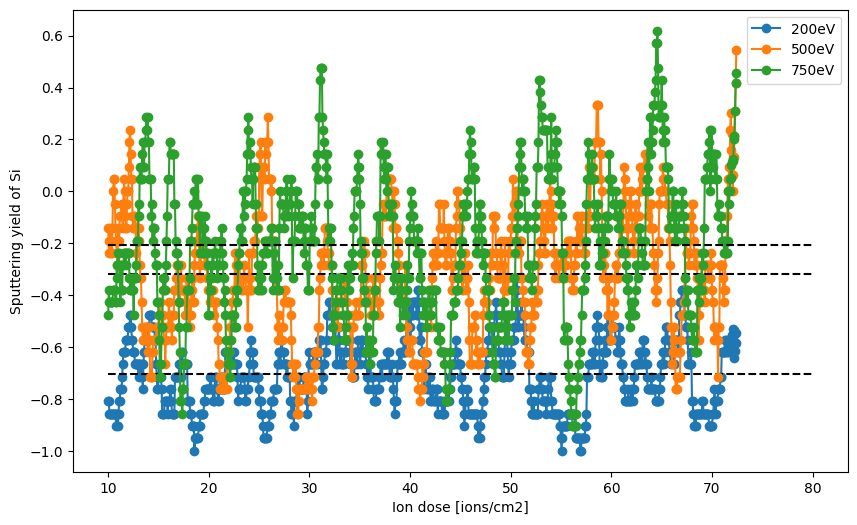

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))

sp_records = SputteringYieldRecordList(records=[])
for sp_config in sp_config_list:
    print(sp_config.label)

    sy_calculator = SputteringYieldCalculator(sp_config.path)
    sp_with_ion_dose_df = sy_calculator.get_sputtering_yield_with_ion_dose(
        area=sp_config.area,
        num_injection=10,
        target_atom_type=target_atom_type
    )
    if sp_config.is_deposited:
        sp_with_ion_dose_df["num_sputtered_atom_avg"] = sp_with_ion_dose_df["num_sputtered_atom_avg"] - 1

    average_sp = sp_with_ion_dose_df["num_sputtered_atom_avg"].mean()

    if sp_config.ion_dose_range is not None:
        sp_with_ion_dose_df_range_filtered = sp_with_ion_dose_df[(sp_with_ion_dose_df["ion_dose"] >= sp_config.ion_dose_range[0]) & (sp_with_ion_dose_df["ion_dose"] <= sp_config.ion_dose_range[1])].copy()
        average_sp = sp_with_ion_dose_df_range_filtered["num_sputtered_atom_avg"].mean()
        ax.plot(sp_with_ion_dose_df_range_filtered["ion_dose"], sp_with_ion_dose_df_range_filtered["num_sputtered_atom_avg"], marker="o", label=sp_config.label)
        ax.plot([sp_config.ion_dose_range[0], sp_config.ion_dose_range[1]], [average_sp, average_sp], linestyle="--", color="black")
    else:
        average_sp = sp_with_ion_dose_df["num_sputtered_atom_avg"].mean()
        ax.plot(sp_with_ion_dose_df["ion_dose"], sp_with_ion_dose_df["num_sputtered_atom_avg"], marker="o", label=sp_config.label)
        ax.plot([ion_dose_range[0], ion_dose_range[1]], [average_sp, average_sp], linestyle="--", color="black")
        sp_with_ion_dose_df_range_filtered = None

    sp_records.records.append(SputteringYieldRecord(
        config=sp_config,
        sp_with_ion_dose_df=sp_with_ion_dose_df,
        sp_with_ion_dose_df_range_filtered=sp_with_ion_dose_df_range_filtered
    ))

# ax.set_ylim(-1, 1.5)
ax.set_xlabel("Ion dose [ions/cm2]")
ax.set_ylabel("Sputtering yield of Si")
ax.legend()

# Ion doseのヒストグラム

Ion dose range: (10, 80)
Label: 200eV
Averange sputtering yield: -0.7054459611527834
95% confident interval -0.713303945298977 ~ -0.6975879770065897
--------------------------------------------------
Ion dose range: (10, 80)
Label: 500eV
Averange sputtering yield: -0.3178175657264003
95% confident interval -0.3321240319747437 ~ -0.3035110994780569
--------------------------------------------------
Ion dose range: (10, 80)
Label: 750eV
Averange sputtering yield: -0.2082142315805518
95% confident interval -0.22460972171167995 ~ -0.19181874144942365
--------------------------------------------------


/var/folders/hl/8xx4rtm50t7czkr79gggbqqr0000gr/T/ipykernel_73987/2758314148.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


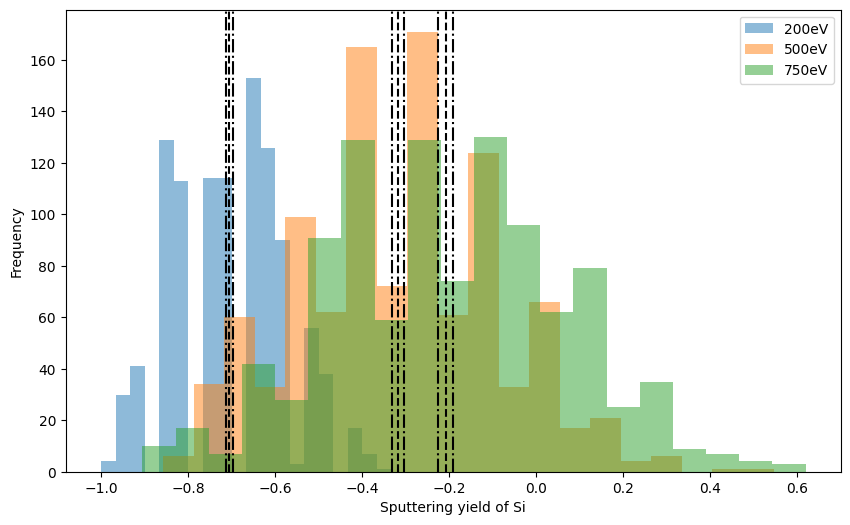

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
for sp_record in sp_records.records:
    if sp_record.config.ion_dose_range is not None:
        target_df = sp_record.sp_with_ion_dose_df_range_filtered.copy()
        print(f"Ion dose range: {sp_record.config.ion_dose_range}")
    else:
        target_df = sp_record.sp_with_ion_dose_df.copy()
    
    avg_sy, std_sy = (target_df['num_sputtered_atom_avg']).mean(), (target_df['num_sputtered_atom_avg']).std()
    lower_confident = avg_sy - 1.96 * std_sy / np.sqrt(len(target_df))
    upper_confident = avg_sy + 1.96 * std_sy / np.sqrt(len(target_df))
    print(f"Label: {sp_record.config.label}")
    print(f"Averange sputtering yield: {avg_sy}")
    print(f"95% confident interval {lower_confident} ~ {upper_confident}")
    print("--------------------------------------------------")

    # plot
    ax.hist(target_df["num_sputtered_atom_avg"], bins=20, label=sp_record.config.label, alpha=0.5)
    ax.axvline(avg_sy, linestyle="--", color="black")
    ax.axvline(lower_confident, linestyle="-.", color="black")
    ax.axvline(upper_confident, linestyle="-.", color="black")

ax.set_xlabel("Sputtering yield of Si")
ax.set_ylabel("Frequency")
ax.legend()
fig.show()

# 1入射あたりのスパッタする原子数 

Number of total timestep: 24000000
Inject atom every 20000 timestep
Number of injected atoms: 1200
Number of sputtered atoms: 359
Max number of sputtered atoms: 3
Label: 200eV Sputtering yield: 0.2991666666666667
Number of total timestep: 24000000
Inject atom every 20000 timestep
Number of injected atoms: 1200
Number of sputtered atoms: 826
Max number of sputtered atoms: 5
Label: 500eV Sputtering yield: 0.6858333333333333
Number of total timestep: 24000000
Inject atom every 20000 timestep
Number of injected atoms: 1200
Number of sputtered atoms: 942
Max number of sputtered atoms: 6
Label: 750eV Sputtering yield: 0.7833333333333333


/var/folders/hl/8xx4rtm50t7czkr79gggbqqr0000gr/T/ipykernel_73987/1129768169.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


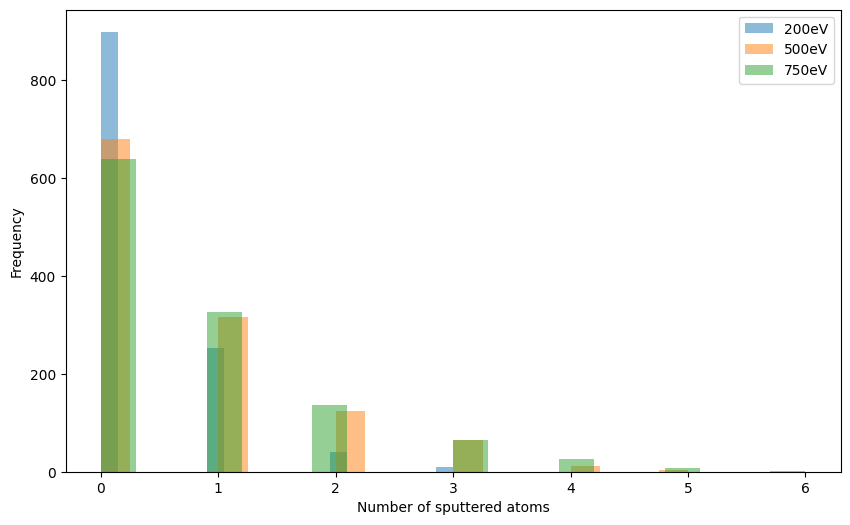

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

for sp_config in sp_config_list:
    sy_calculator = SputteringYieldCalculator(sp_config.path)
    injected_sputtered_atoms_df = sy_calculator.get_injected_and_sputtered_atoms(
        target_atom_type=target_atom_type
    )
    print(f"Max number of sputtered atoms: {injected_sputtered_atoms_df['num_sputtered_atoms'].max()}")
    injected_sputtered_atoms_df = injected_sputtered_atoms_df[injected_sputtered_atoms_df["num_sputtered_atoms"] < 100]
    print(f"Label: {sp_config.label}", f"Sputtering yield: {injected_sputtered_atoms_df['num_sputtered_atoms'].mean()}")
    ax.hist(injected_sputtered_atoms_df["num_sputtered_atoms"], bins=20, label=sp_config.label, alpha=0.5)

ax.set_xlabel("Number of sputtered atoms")
ax.set_ylabel("Frequency")
# ax.set_xlim(0, 3)
ax.legend()
fig.show()